In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [44]:
def load():
    data = pd.read_csv("datasets/titanic.csv")
    return data


df = load()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


## 1. Outliers 
We can viualize the outliers using sns.boxplot to represent a probability distribution.
IQR = Q3 (%25) - Q1 (%75)

IQR is used to choose upper and lower bounds, any thing not in between is an outlier.

Upper bound = Q3 + 1.5 * IQR 

Lower bound = Q1 - 1.5 * IQR


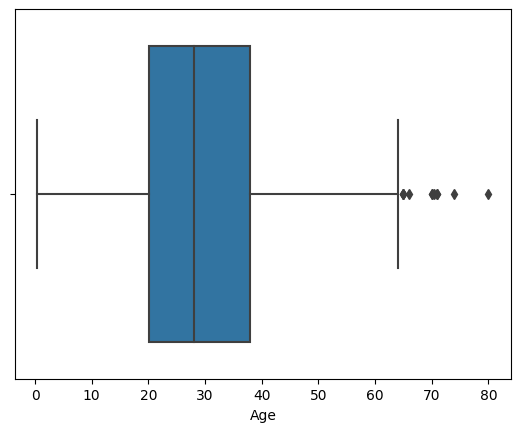

In [45]:
sns.boxplot(x=df["Age"])
plt.show()

In [46]:
q1 = df["Age"].quantile(0.25)
q3 = df["Age"].quantile(0.75)
iqr = q3 - q1

print(f"Lower quartile: {q1}, Upper quartile: {q3}, IQR: {iqr}")

up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr

print(f"Upper bound: {up}, Lower bound: {low}")


Lower quartile: 20.125, Upper quartile: 38.0, IQR: 17.875
Upper bound: 64.8125, Lower bound: -6.6875


In [47]:
df[(df["Age"] < low)  |  (df["Age"] > up)].index

Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [48]:
### Turn into functions ###

def outlier_thresholds(dataframe, col_name, q1_val=0.25, q3_val=0.75):
    q1 = dataframe[col_name].quantile(q1_val)
    q3 = dataframe[col_name].quantile(q3_val)
    iqr = q3 - q1
    upper_limit = q3 + iqr * 1.5
    lower_limit = q1 - iqr * 1.5
    return upper_limit, lower_limit

outlier_thresholds(df, "Age")


(64.8125, -6.6875)

In [49]:
def check_outlier(dataframe, col_name):
    up_limit, low_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | 
                 (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
check_outlier(df, "Age")

True

In [50]:

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
        Return catagorical, numeric, catagorical bu cardinal variable names from a dataframe.
        Note: Catagorical includes numeric values which have less than the cat_threshold (default -> less than 10)

    Parameters
    ------
        dataframe: dataframe
        cat_th: int, optional
        car_th: int, optinal
    Returns
    ------
        cat_cols: list
        num_cols: list
        cat_but_car: list

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total var. number
        num_but_cat is included in cat_cols
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    #is a number but has less than "cat_th" amount of unique values (counted as catagorical)
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    #not numerical but has more than "car_th" amount of unique values (not catagorical)
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    
    #cat_cols = cat_cols + num_but_cat - cat_but_car
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols -> numerical and not in
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [51]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if col not in "PassengerId"] #dont include

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [52]:
for col in num_cols:
    print(col, check_outlier(df,col))

Age True
Fare True


In [53]:
def grab_outliers(dataframe, col_name, index=False):
    up, low = outlier_thresholds(dataframe, col_name)
    outliers = dataframe[(dataframe[col_name] > up) | (dataframe[col_name] < low)]
    
    if outliers.shape[0] > 10:
        print(outliers.head())
    else: 
        print(outliers) 
    if index:
        return outliers.index

grab_outliers(df, "Age", index=True)

     PassengerId  Survived  Pclass                            Name   Sex    Age  SibSp  Parch      Ticket   Fare Cabin Embarked
33            34         0       2           Wheadon, Mr. Edward H  male 66.000      0      0  C.A. 24579 10.500   NaN        S
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male 65.000      0      1      113509 61.979   B30        C
96            97         0       1       Goldschmidt, Mr. George B  male 71.000      0      0    PC 17754 34.654    A5        C
116          117         0       3            Connors, Mr. Patrick  male 70.500      0      0      370369  7.750   NaN        Q
280          281         0       3                Duane, Mr. Frank  male 65.000      0      0      336439  7.750   NaN        Q


Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

### Dealing with Outliers
1. Deleting
2. Re-assignment with tresholds

In [54]:
up, low = outlier_thresholds(df, "Fare")
deleted = df[~((df["Fare"] < low) | (df["Fare"] > up))]

print(f"Before: {df.shape}, After: {deleted.shape}")

Before: (891, 12), After: (775, 12)


In [55]:
def remove_outliers(dataframe, col_name):
    up, low = outlier_thresholds(dataframe, col_name)
    df_wo_outliers = dataframe[~((df[col_name] < low) | (df[col_name] > up))]
    return df_wo_outliers

cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if col not in "PassengerId"]

for col in num_cols:
    new_df= remove_outliers(df, col)

print(f"Has deleted {df.shape[0] - new_df.shape[0]} columns")

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
Has deleted 116 columns


In [56]:
##Re-assignment with thresholds##

def replace_with_threshold(dataframe, var):
    up, low = outlier_thresholds(dataframe, var)
    dataframe.loc[(dataframe[var] > up), var] = up
    dataframe.loc[(dataframe[var] < low), var] = low

In [57]:
replace_with_threshold(df, "Fare")
df.loc[(df["Fare"] < low) | (df["Fare"] > up), "Fare"]


Series([], Name: Fare, dtype: float64)

In [58]:
print(check_outlier(df, "Fare"))

False


In [59]:
###Recap###
df = load()

up, low = outlier_thresholds(df, "Age")
bool = check_outlier(df,"Age")

print(f"##Outlier thresholds##\n {up,low}")
print(f"##Outliers exist?##\n {bool}")
print("\n##Print outliers##")

grab_outliers(df, "Age")

#remove_outliers(df,"Age")
replace_with_threshold(df,"Age")
bool = check_outlier(df, "Age")
print(f"\n##Outliers after replacement?##\n {bool}")


##Outlier thresholds##
 (64.8125, -6.6875)
##Outliers exist?##
 True

##Print outliers##
     PassengerId  Survived  Pclass                            Name   Sex    Age  SibSp  Parch      Ticket   Fare Cabin Embarked
33            34         0       2           Wheadon, Mr. Edward H  male 66.000      0      0  C.A. 24579 10.500   NaN        S
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male 65.000      0      1      113509 61.979   B30        C
96            97         0       1       Goldschmidt, Mr. George B  male 71.000      0      0    PC 17754 34.654    A5        C
116          117         0       3            Connors, Mr. Patrick  male 70.500      0      0      370369  7.750   NaN        Q
280          281         0       3                Duane, Mr. Frank  male 65.000      0      0      336439  7.750   NaN        Q

##Outliers after replacement?##
 False


### LOF - Local Outlier Factor
Used for finding anomalies of variables with respect to its neighbours.
...

In [60]:
df = sns.load_dataset("diamonds")
df = df.select_dtypes(include=["float64", "int64"])
df = df.dropna()
df.head()

,carat,depth,table,price,x,y,z
0,0.230,61.500,55.000,326,3.950,3.980,2.430
1,0.210,59.800,61.000,326,3.890,3.840,2.310
2,0.230,56.900,65.000,327,4.050,4.070,2.310
3,0.290,62.400,58.000,334,4.200,4.230,2.630
4,0.310,63.300,58.000,335,4.340,4.350,2.750


In [61]:
for col in df.columns:
    up, low = outlier_thresholds(df, col)
    print(col, df[((df[col] < low) |  (df[col] > up))].shape[0])
    
##some are a lot!!

carat 1889
depth 2545
table 605
price 3540
x 32
y 29
z 49


In [62]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)

df_scores = clf.negative_outlier_factor_
df_scores[0:5] #since - , as value gets smaller gets worse

array([-1.58352526, -1.59732899, -1.62278873, -1.33002541, -1.30712521])

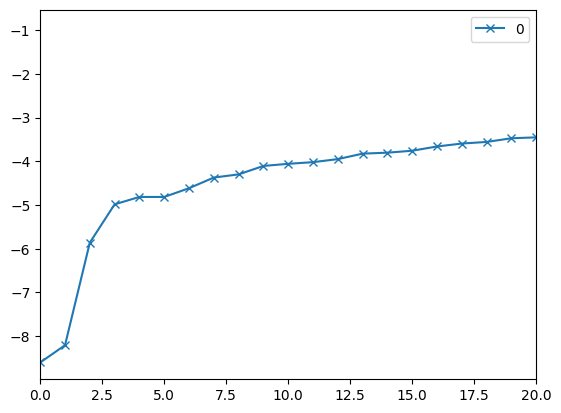

In [63]:
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0,20], style= "x-")
plt.show()

In [64]:
#We need to choose the threshold
#we can go for a big slope, here around [2] and [3]
th = np.sort(df_scores)[3]
print(f"Threshold chosen as {th}")

df[df_scores < th]

#Why are these outliers? 
#Not necessarly because of one variable being an outlier, 
#but multiple var. in relation with each other.

Threshold chosen as -4.984151747711709


,carat,depth,table,price,x,y,z
41918,1.030,78.200,54.000,1262,5.720,5.590,4.420
48410,0.510,61.800,54.700,1970,5.120,5.150,31.800
49189,0.510,61.800,55.000,2075,5.150,31.800,5.120
